# Question 2

In [1]:
import numpy as np
import pandas as pd
import graphviz
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def viznn(input,weights_input_hidden,weights_hidden_output):
    # calculate the values of the neurons in the hidden layer & ouputlayer 
    hidden_values = np.dot(input, weights_input_hidden)
    output_values = np.dot(hidden_values, weights_hidden_output)

    # create a new graph object
    g = graphviz.Digraph(format='png')#, size="10,8",nodesep ="1.5")
    g.attr(splines='line')  # set the edges to use straight lines
    g.attr(rankdir='BT') # change the layout to rankdir='BT' for bottom-to-top orientation

    # add nodes
    g.node('x1', label=f'{input[0]}')
    g.node('x2', label=f'{input[1]}')
    g.node('h1', label=f'{hidden_values[0]:.2f}')
    g.node('h2', label=f'{hidden_values[1]:.2f}')
    g.node('h3', label=f'{hidden_values[2]:.2f}')
    g.node('y1', label=f'{output_values[0]:.2f}')
    g.node('y2', label=f'{output_values[1]:.2f}')

    # connect nodes from input to hidden layer with weights
    for i, input in enumerate(['x1', 'x2']):
        for j, h in enumerate(['h1', 'h2', 'h3']):
            weight = weights_input_hidden[i, j]
            g.edge(input, h, label=f'{weight:.1f}')

    # connect nodes from hidden to output layer with weights
    for i, h in enumerate(['h1', 'h2', 'h3']):
        for j, y in enumerate(['y1', 'y2']):
            weight = weights_hidden_output[i, j]
            g.edge(h, y, label=f'{weight:.1f}')

    return g

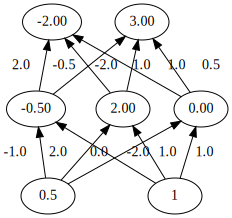

In [3]:
# define the weights
weights_input_hidden = np.array([[-1.0, 2.0, -2.0], [0.0, 1.0, 1.0]])
weights_hidden_output = np.array([[2.0, -2.0], [-0.5, 1.0], [1.0, 0.5]])

viznn([0.5, 1],weights_input_hidden,weights_hidden_output)

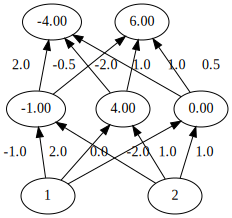

In [4]:
viznn([1, 2],weights_input_hidden,weights_hidden_output)

# Question 3

In [5]:
df = pd.read_csv('data.csv')
df.drop("Unnamed: 0", axis= 1, inplace=True) #drop first column
df.shape

(10000, 82)

In [6]:
df = df.apply(pd.to_numeric, errors='coerce') #check for errors (if not numeric type --nan)
df.dropna(inplace=True) #drop rows with nan
df = df.astype('int64')
df.shape    

(9358, 82)

In [7]:
# identify and replace outliers with NA
for col in df.columns:
    outliers = (df[col] < 0) | (df[col] >= 1000) #drop rows with outliers
    df.loc[outliers, col] = np.nan
df.dropna(inplace=True) #drop rows with nan
df.shape

(9357, 82)

## 3.1

In [8]:
#split the data into training and testing sets
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123456)

In [9]:
#prints out the classification report and confusion matrix for the models
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\033[34m{model.__class__.__name__}\033[0m")
    print(f"    \033[32mClassification Report:\033[0m")
    for line in classification_report(y_test, y_pred).split('\n'):
        print(f"        {line}")
    print(f"    \033[32mConfusion Matrix:\033[0m")
    for line in str(confusion_matrix(y_test, y_pred)).split('\n'):
        print(f"        {line}")
    print()

#build SVM and Random Forest classifiers and fit them to the training data.
random_st= 213456 #for reproduceability

svm = SVC(kernel='linear',random_state=random_st)
svm.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=random_st)
rf.fit(X_train, y_train)

evaluate(svm, X_test, y_test)
evaluate(rf, X_test, y_test)

SVC
    Classification Report:
                      precision    recall  f1-score   support
        
                 0.0       0.99      0.98      0.99      1667
                 1.0       0.88      0.90      0.89       205
        
            accuracy                           0.97      1872
           macro avg       0.93      0.94      0.94      1872
        weighted avg       0.98      0.97      0.98      1872
        
    Confusion Matrix:
        [[1641   26]
         [  21  184]]

RandomForestClassifier
    Classification Report:
                      precision    recall  f1-score   support
        
                 0.0       0.89      1.00      0.94      1667
                 1.0       1.00      0.01      0.03       205
        
            accuracy                           0.89      1872
           macro avg       0.95      0.51      0.49      1872
        weighted avg       0.90      0.89      0.84      1872
        
    Confusion Matrix:
        [[1667    0]
         [ 2

In [10]:
#We can also perform cross-validation to get a better estimate of the model's performance.
scores_svm = cross_val_score(svm, X, y, cv=5)
scores_rf = cross_val_score(rf, X, y, cv=5)

print(f"SVM Cross-validation scores: {scores_svm}")
print(f"Random Forest Cross-validation scores: {scores_rf}")


SVM Cross-validation scores: [0.97596154 0.97115385 0.97594869 0.97862106 0.97006948]
Random Forest Cross-validation scores: [0.87980769 0.87980769 0.87867451 0.87867451 0.87707108]


## 3.2

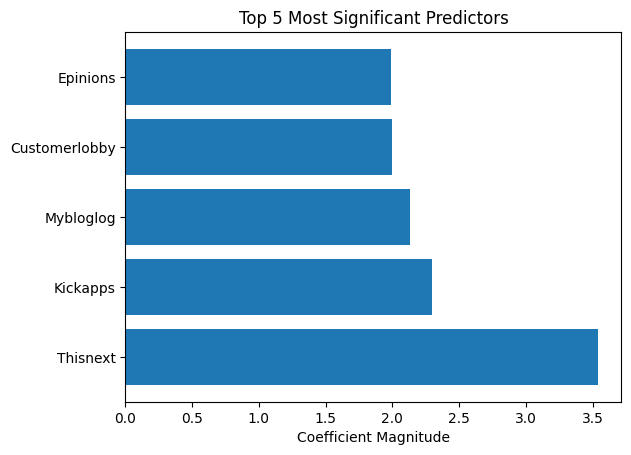

{'Thisnext': 3.54,
 'Kickapps': 2.3,
 'Mybloglog': 2.13,
 'Customerlobby': 2.0,
 'Epinions': 1.99}

In [11]:
def find_top_features(model, feature_names, num_features=5):
    coef = model.coef_[0]
    coef_abs = abs(coef)
    sorted_coef_idx = coef_abs.argsort()[::-1][:num_features]
    top_features = [feature_names[i] for i in sorted_coef_idx]
    return top_features

def plot_top_features(model, feature_names, num_features=5):
    coef = model.coef_[0]
    coef_abs = abs(coef)
    sorted_coef_idx = coef_abs.argsort()[::-1][:num_features]
    top_features = [feature_names[i] for i in sorted_coef_idx]
    top_coefs = coef[sorted_coef_idx]
    plt.barh(top_features, top_coefs)
    plt.xlabel('Coefficient Magnitude')
    plt.title('Top {} Most Significant Predictors'.format(num_features))
    plt.show()
    
    # Create a dictionary of top features and their coefficients
    feature_dict = dict(zip(top_features, top_coefs.round(2)))
    return feature_dict

#plot the top 5 features for the SVM model
plot_top_features(svm, X.columns, num_features=5)



## 3.3
(see pdf)

## 3.4

Top 5 channels based on cost per click:
Index(['Youtube', 'Facebook', 'Myspace', 'Blogger', 'Twitter'], dtype='object')


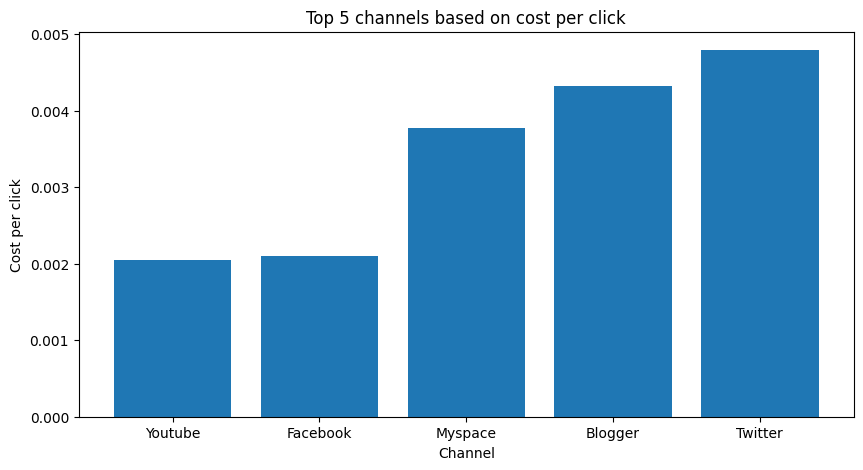

In [15]:
# Function to calculate cost per click per channel
def cost_per_click(df):
    impressions = df.iloc[:,:-1].sum()
    clicks = df.iloc[:,-1].sum()
    cost_per_impression = 0.1 # assuming 0.10 DKK per impression
    cost_per_click = (cost_per_impression * clicks) /impressions
    return cost_per_click

# Calculate cost per click for each channel
costs = cost_per_click(df)

# Print top five best channels based on cost per click
top_five_channels = costs.nsmallest(5).index
print("Top 5 channels based on cost per click:")
print(top_five_channels)

# create a bar plot of the top 5 channels
plt.figure(figsize=(10,5))
plt.bar(top_five_channels, costs[top_five_channels])
plt.title('Top 5 channels based on cost per click')
plt.xlabel('Channel')
plt.ylabel('Cost per click')
plt.show()
